<a href="https://colab.research.google.com/github/ehstowe/datascience/blob/main/PredictingFire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project: Predicting Fire

Emma Stowe  
DSC 305a SP20  
Final Project: Predicting Fire


#Summary
This project is an analysis of data collected by the City of Detroit regarding fires in 2015. The data includes the time and date of almost 20,000 emergency calls, the geographic coordinates of the location the call was made from, the type of structure the call is reporting from (single family home, apartment building, business, school, etc), the time and date of dispatch, time and date of the crew's arrival to the scene, time and date the scene was cleared, and any injuries  or fatalities reported. The part of the dataset I chose to focus on was the recording of false alarms. 

I wanted to investigate this question: Can we predict false alarms when they are made? False alarms cost fire departments - and therefore, taxpayers - billions of dollars each year. With a perfect model, much of this money could be better spent. Even an imperfect model could help fire departments know how to best allocate their resources, sending less experienced crews or less equipped trucks to the scene. Finally, if the results were generalizable, this could greatly help fire stations in more rural areas where they may only have one or two firetrucks for a large service area. 

I tried many models in an attempt to find one to classify a call as a False Alarm or Not a False Alarm. I was not able to find a perfect one, but some are better than others. My best models are a Random Forest Classifier and a Gradient Boosting Classifier, both with tuned hyperparameters. 

A major challenge of this problem is that the data is highly skewed. There are significantly more non-false alarms (I considered these the negative class) than false alarms (positive class). That means that models that classify all calls as non-false alarms have relatively high accuracy. This is the idea that fire departments currently work with, so I wanted to do better. Still, I recognize that a false positive (predicting a call was a false alarm when it was not) has an extreme cost in this case, much more than a false negative (predicting a call was not a false alarm when it was). So, I created a new benchmark, combining precision and recall like F1 score does, but giving more weight to precision because a higher precision means fewer false positives. My benchmark weights precision at .75 and recall at .25. 


The following functions are included in the "General Functions" code cell: 
</ul>
<li>Binarizing a column: takes in a column name and a dataframe and adds all necessary columns to the dataframe</li>
<li>Evaluate binary: takes in the true values and the predicted values and displays a confusion matrix and prints the accuracy, precision, recall, F1, and benchmark scores, as well as area under the ROC curve.</li>
<li>Run classifier: takes a classifier and training and testing data and runs that classifier on the data, then appends the values for accuracy, precision, recall, F1, benchmark, and area under the ROC curve onto their respective arrays.</li>
<li>Show max stats: takes training and testing data, empty arrays accuracy, precision, recall, F1, and benchmark, area under the ROC curve, and a list of classifiers and runs each classifier in the list through the 'run classifier' function, outputs the classifier with the highest value in each array. </li>

In [ ]:
#@title Import Statements
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import datasets, svm, metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.utils import resample 
from sklearn.ensemble import RandomForestClassifier
from numpy import nan
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid as NC
from sklearn.multiclass import OneVsRestClassifier as OVRC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title General Functions
def go_through_set(colName, df):
    for x in set(df[colName]):
        x = str(x)
        create_new_col(x, colName, x, df)
def create_new_col(newColName, oldColName, whatIs1, df):
    df[newColName]=df[oldColName].apply(lambda x: 1 if(x==whatIs1) else 0)

def evaluate_binary(y_true, y_pred):
  data = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (6,2))
  sns.set(font_scale=1)#for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')
  print("---------------------------------------------------")
  accuracy_clf=float(str(metrics.accuracy_score(y_test, y_pred))[0:6])
  precision_clf=float(str(metrics.precision_score(y_test, y_pred, pos_label=1))[0:6])
  recall_clf=float(str(metrics.recall_score(y_test, y_pred))[0:6])
  f1_clf=float(str(metrics.f1_score(y_test, y_pred))[0:6])
  benchmark_clf=float(str((precision_clf*3+recall_clf)/4)[0:6])
  auc_clf=float(str(metrics.roc_auc_score(y_true, y_pred, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None))[0:6])
  print('Accuracy: ',accuracy_clf)
  print('Precision: ',precision_clf)
  print('Recall: ',recall_clf)
  print('F1: ', f1_clf)
  print('Benchmark:', benchmark_clf)
  print('AUC:',auc_clf)
  print("---------------------------------------------------")


def run_classifier(clf, X_train0, X_test0, y_train0, y_test0):
  model=clf()
  model.fit(X_train0, y_train0)
  y_pred=model.predict(X_test0)
  accuracy_clf=float(str(metrics.accuracy_score(y_test0, y_pred))[0:6])
  precision_clf=float(str(metrics.precision_score(y_test0, y_pred, pos_label=1))[0:6])
  recall_clf=float(str(metrics.recall_score(y_test0, y_pred))[0:6])
  f1_clf=float(str(metrics.f1_score(y_test0, y_pred))[0:6])
  benchmark_clf=float(str((precision_clf*3+recall_clf)/4)[0:6])
  auc_clf=float(str(metrics.roc_auc_score(y_test0, y_pred, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None))[0:6])
  model_name = type(model).__name__
  accuracy.append(accuracy_clf)
  precision.append(precision_clf)
  recall.append(recall_clf)
  f1.append(f1_clf)  
  benchmark.append(benchmark_clf)
  auc.append(auc_clf)

def show_max_stats(X_train0, X_test0, y_train0, y_test0, classifiers, accuracy, precision, recall, f1, benchmark, auc):
  stats = [accuracy, precision, recall, f1, benchmark, auc]
  stats_strings=['accuracy', 'precision', 'recall', 'f1', 'benchmark', 'auc']
  classifier_strings=['LogisticRegression', 'RandomForestClassifier', 'GaussianNB', 'BernoulliNB', 'DecisionTreeClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'svm.SVC', 'Perceptron', 'LDA', 'MLPClassifier', 'ABC', 'GBC', 'Perceptron']
  for clf in classifiers:
    run_classifier(clf, X_train0, X_test0, y_train0, y_test0) 

  print('----------------------------------------------------------')

  for measure in range(6):
    counter=0
    i_max=0
    i_max=stats[measure][0]
    i_max_index=0
    for x in stats[measure]:
      if x>i_max:
        i_max=x
        i_max_index=counter
        model=classifier_strings[i_max_index]
      counter=counter+1
      
    print('max '+stats_strings[measure]+'='+model+' at '+str(i_max))

  print('----------------------------------------------------------')

#Data Exploration and Preparation

In [ ]:
#@title Reading and Cleaning Data
def clean_fireData(fire):  
  #drop duplicates
  duplicates = fire.duplicated(subset=None, keep='first')
  fire=fire.drop_duplicates()

  #drop columns missing lots of data
  fire = fire.drop(columns=['DETECTOR', 'STRUCTURE STATUS'])

  #drop rows with missing data (not many, once columns are removed above)
  #fire = fire.dropna()

  #convert necessary columns to datetime objects
  cols_to_convert_to_datetime = ['DATE OF CALL', 'TIME OF CALL', 'DATE OF DISPATCH', 'TIME OF DISPATCH', 'DATE OF ARRIVAL', 'TIME OF ARRIVAL', 'DATE UNIT CLEARED', 'TIME UNIT CLEARED']
  for col in cols_to_convert_to_datetime:
    fire[col]=pd.to_datetime(fire[col])

  #make broader categories of property use
  fire['PROPERTY_USE_GENERAL']=fire['PROPERTY USE'].apply(lambda x: x if checkIfInTopPlaces(x)==True else 'Other')

  #binarize property use broader categories
  go_through_set('PROPERTY_USE_GENERAL', fire)

  #create new columns for hour and month of call
  fire['CALL HOUR']=fire['TIME OF CALL'].apply(lambda x: x.hour)
  fire['CALL MONTH']=fire['DATE OF CALL'].apply(lambda x: x.month)
  fire['CALL DAY OF WEEK']=fire['DATE OF CALL'].apply(lambda x: x.dayofweek)

  return fire


fire = pd.read_csv('fire.csv')

props = fire['PROPERTY USE']
counts = props.value_counts()
counts.to_string()
topPlaces = counts[0:30]
topPlacesDf = pd.DataFrame(topPlaces)
topPlacesDf['Property Type']=topPlacesDf.index
topPlacesDf['Count']=topPlacesDf['PROPERTY USE']
topPlacesDf = topPlacesDf.drop(columns='PROPERTY USE')
topPlacesDf = topPlacesDf.drop(index='Property Use, other')
def checkIfInTopPlaces(x):
  for place in topPlacesDf['Property Type']:
    if x==place:
      return True
  return False

fire = clean_fireData(fire)
fire.head(3)

,EXPOSURE,ADDRESS,INCIDENT #,INCIDENT TYPE,INCIDENT TYPE CATEGORY,PROPERTY USE,ENGINE AREA,DATE OF CALL,TIME OF CALL,DATE OF DISPATCH,TIME OF DISPATCH,DATE OF ARRIVAL,TIME OF ARRIVAL,DATE UNIT CLEARED,TIME UNIT CLEARED,CIVILIAN INJURY,CIVILIAN FATALITY,FIRE PERSONNEL INJURY,FIRE PERSONNEL FATALITY,X,Y,LOCATION,PROPERTY_USE_GENERAL,Other,"Motor vehicle or boat sales, services, r",High school/junior high school/middle sc,"Service station, gas station","Parking garage, (detached residential ga","Church, mosque, synagogue, temple, chape",Convenience store,"Manufacturing, processing",Highway or divided highway,"Street, other","Mercantile, business, other","24-hour care Nursing homes, 4 or more pe",Warehouse,"Elementary school, including kindergarte","Residential street, road or residential",Vehicle parking area,Restaurant or cafeteria,Vacant lot,Open land or field,"Residential, other",Business office,"Schools, non-adult",Undetermined,Bar or nightclub,Street or road in commercial area,"Outside or special property, other","Hotel/motel, commercial","Food and beverage sales, grocery store",1 or 2 family dwelling \ House \ Residen,Multifamily dwellings \ Apartments,CALL HOUR,CALL MONTH,CALL DAY OF WEEK
0,No,"PLYMOUTH RD / MEYERS RD, Detroit",16,"700 - False alarm or false call, other","FALSE ALARM, FALSE CALL","Street, other",E42,2015-01-01,2020-05-14 03:02:47,2015-01-01,2020-05-14 03:04:11,2015-01-01,2020-05-14 03:11:28,2015-01-01,2020-05-14 03:14:06,0,0,0,0,-9258236.220,5217052.339,"(5217052.33870992, -9258236.21953809)","Street, other",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,3
1,No,"18321 FAUST AVE, Detroit",53,745 - unintentional,"FALSE ALARM, FALSE CALL",1 or 2 family dwelling \ House \ Residen,E59,2015-01-01,2020-05-14 16:08:33,2015-01-01,2020-05-14 16:10:23,2015-01-01,2020-05-14 16:13:44,2015-01-01,2020-05-14 16:14:45,0,0,0,0,-9264467.798,5224699.499,"(5224699.4990991, -9264467.79848532)",1 or 2 family dwelling \ House \ Residen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,16,1,3
2,No,"18050 HAYES ST, Detroit",75,"710 - Malicious, mischievous false call, other","FALSE ALARM, FALSE CALL",1 or 2 family dwelling \ House \ Residen,E50,2015-01-01,2020-05-14 21:58:48,2015-01-01,2020-05-14 21:59:41,2015-01-01,2020-05-14 22:03:37,2015-01-01,2020-05-14 22:04:47,0,0,0,0,-9235639.782,5225437.056,"(5225437.05637783, -9235639.78220764)",1 or 2 family dwelling \ House \ Residen,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,21,1,3


I found the dataset [here](https://data.world/detroit/detroit-2015-fire-data). The columns are: exposure, address, incident number, incident type, incident type category, property use, engine area, date of call, time of call, date of dispatch, time of dispatch, date of arrival, time of arrival, date unit cleared, time unit cleared, detector, number civilian injury, number civilian fatality, number fire personell injury, number fire personell fatality, structure status, latitude, longitude, and location (both latitude and longitude). These columns are mostly self explanatory, but I did have to study to learn that "incident type category" is more broad categories than "incident type."

The first step in my data prepping process was to remove one duplicate row. Then I removed the columns "Detector" and "Structure Status" because they were both mostly null values. Once I had removed them, only a few columns (less than 10) contained null values, and they were not in any of the columns I needed for my classification models.

I converted all time and date columns to datetime objects and created new columns "Call Hour," "Call Month," and "Call Day of Week" by extracting this information from the datetimes. 

The hardest step of the data prep process was that I wanted to use the information from the "Property use" column. Previously I've written functions that quickly binarize all the value that appear in the column, but there were too many in this column to do that. There were over 40, and many only had one or two ocurrances. So, I created a new dataframe of the top 25 most common property uses and grouped the rest together in an "Other" category. Then I only binarized these top 25 (I experimented with running the models with more or less than 25, and found it to be an appropriate threshold.) 

I used the following features as independent variables: latitude, longitude, call hour, call month, call day of week, and the binarized property uses. 


#Model Fitting
I found myself writing the same code over and over again for different classifiers and trying to figure out which one was the closest to solving my problem. This is what inspired me to create the new benchmark statistic as well as to write a function that tried all of the classifiers and output the best one by each measurement. I first did this with a standard test/train split of the data - disregarding the imbalanced number of false alarms, and got results that are slightly better than chance. Next, I balanced the data - making sure to balance AFTER the test/train split to avoid data leakage - and ran the new training and testing data through the same loop. The results did not improve; they were slightly worse. But in both cases, The Random Forest Classifier stood out as the best model, with GBC also showing high precision. 

This finding corresponds with the results in [this](https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f) article from <i>Toward Data Science</i> which discusses the best machine learning models for imbalanced datasets. I learned from the article that these two classifiers are actually fairly similar. Both are a forest of decision trees and each tree takes into account different subsets of variables and training data. The difference is that each time the Gradient Boosting Classifier builds a tree, it attempts to fix the mistakes made in the previous ones. 

Because I did not get much better results with the balanced data, I stuck to the original imbalanced data when tuning hyperparameters. I used a grid search with code from [this](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) article, also from <i>Toward Data Science</i>, and found the following ideal hyperparameters: 

<ul>
<li>bootstrap: True</li>
<li>max_depth: 40</li>
<li>min_samples_leaf: 2</li>
<li>min_samples_split: 10</li>
<li>n_estimators: 2000</li>
</ul>

I ran the same grid search on the GBC model and found these hyperparameters:
<ul>
<li>learning_rate: .001</li>
<li>max_depth: 60</li>
<li>min_samples_leaf: 4</li>
<li>min_samples_split: 5</li>
<li>n_estimators: 1600</li>
<li>subsample: .25</li>
</ul>

Because the grid searches took almost an hour to run, and 4 and a half hours, respectively, I commented them out, but they can be found below. 

In [ ]:
#@title Finding the best model: imbalanced data
X_labels=['X', 'Y', 'CALL DAY OF WEEK', 'CALL HOUR', 'CALL MONTH']
for label in topPlacesDf['Property Type']:
  X_labels.append(str(label))
X=fire[X_labels]


y=fire['INCIDENT TYPE CATEGORY'].apply(lambda x: 1 if (x=='FALSE ALARM, FALSE CALL') else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

classifiers=[LogisticRegression, RandomForestClassifier, GaussianNB, BernoulliNB, DecisionTreeClassifier, BaggingClassifier, ExtraTreesClassifier, svm.SVC, Perceptron, LDA, MLPClassifier, ABC, GBC, Perceptron]
accuracy=[]
precision=[]
recall=[]
f1=[]
benchmark=[] #precision*3 + recall /4
auc=[]

show_max_stats(X_train, X_test, y_train, y_test, classifiers, accuracy, precision, recall, f1, benchmark, auc)
'''print(accuracy)
print(precision)
print(recall)
print(f1)
print(benchmark)'''



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


----------------------------------------------------------
max accuracy=RandomForestClassifier at 0.7087
max precision=GBC at 0.691
max recall=Perceptron at 0.4679
max f1=DecisionTreeClassifier at 0.4545
max benchmark=GBC at 0.5624
max auc=RandomForestClassifier at 0.622
----------------------------------------------------------


'print(accuracy)\nprint(precision)\nprint(recall)\nprint(f1)\nprint(benchmark)'

In [ ]:
#@title Finding the best model: balanced data { form-width: "20px" }
fire['Class Label']=fire['INCIDENT TYPE CATEGORY'].apply(lambda x: 1 if (x=='FALSE ALARM, FALSE CALL') else 0)

X_labels2=['X', 'Y', 'CALL DAY OF WEEK', 'CALL HOUR', 'CALL MONTH', 'Class Label']
for label in topPlacesDf['Property Type']:
  X_labels2.append(str(label))  
X2=fire[X_labels2]
y2=fire['Class Label']

X_train2, X_test2, y_train2, y_test2=train_test_split(X2, y2, random_state=0)

positive=X_train2[X_train2['Class Label']==1]
negative=X_train2[X_train2['Class Label']==0]

df_negative_upsampled = resample(negative, replace=True, n_samples=4829, random_state=123)
X_train2=pd.concat([positive, df_negative_upsampled])
y_train2=X_train2['Class Label']
X_train2=X_train2.drop(columns='Class Label')
X_test2=X_test2.drop(columns='Class Label')

scaler=StandardScaler().fit(X_train2)
X_train2=scaler.transform(X_train2)
X_test2=scaler.transform(X_test2)


classifiers=[LogisticRegression, RandomForestClassifier, GaussianNB, BernoulliNB, DecisionTreeClassifier, BaggingClassifier, ExtraTreesClassifier, svm.SVC, Perceptron, LDA, MLPClassifier, ABC, GBC, Perceptron]
accuracy.clear()
precision.clear()
recall.clear()
f1.clear()
benchmark.clear() #precision*3 + recall /4
auc.clear()

show_max_stats(X_train2, X_test2, y_train2, y_test2, classifiers, accuracy, precision, recall, f1, benchmark, auc)
'''print(accuracy)
print(precision)
print(recall)
print(f1)
print(benchmark)'''



/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


----------------------------------------------------------
max accuracy=GaussianNB at 0.6959
max precision=GaussianNB at 0.5827
max recall=ExtraTreesClassifier at 0.7185
max f1=RandomForestClassifier at 0.5534
max benchmark=RandomForestClassifier at 0.5172
max auc=RandomForestClassifier at 0.6422
----------------------------------------------------------


'print(accuracy)\nprint(precision)\nprint(recall)\nprint(f1)\nprint(benchmark)'

In [ ]:
#@title Hyperparameters Grid Search: Random Forest Model { form-width: "20px" }
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

'''rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train2, y_train2)

rf_random.best_params_'''

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


'rf = RandomForestClassifier()\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\nrf_random.fit(X_train2, y_train2)\n\nrf_random.best_params_'

In [ ]:
#@title Hyperparameters Grid Search: GBC model { form-width: "20px" }

loss=['deviance', 'exponential']
learning_rate=[.1, .05, .001, .2, .3]
max_depth=[2, 4, 8, 12]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
subsample=[.25, .5, 1.0]
min_samples_split=[2, 5, 10]
min_samples_leaf=[1, 2, 4]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)


random_grid = {'loss':loss, 'learning_rate':learning_rate, 'max_depth':max_depth, 'n_estimators':n_estimators, 'subsample':subsample, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf, 'max_depth':max_depth} 

print(random_grid)

'''gbc = GBC()
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gbc_random.fit(X_train, y_train)

gbc_random.best_params_'''

{'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.05, 0.001, 0.2, 0.3], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'subsample': [0.25, 0.5, 1.0], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


'gbc = GBC()\ngbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\ngbc_random.fit(X_train, y_train)\n\ngbc_random.best_params_'

#Model Evaluation and Selection
Using a grid search to find the best hyperparameters strengthened both models.

####<u>Random Forest Model</u>
The hyperparameters decreased the number of false positives from 398 to 263 and increased the benchmark score from .543 to .570, an increase of almost 5%. This came at the cost of some of the true positives - the original hyperparameter-less random forest model classified a record 603 false alarms as actual false alarms, and this number decreased to 506 in the improved model. 

The main advantage of the Random Forest Model over the GBC is that it is slightly faster, and time is of the essence in a fire department. It also does have a slightly higher AUC, but because false positives have a much higher cost, I do not think this slight difference strongly supports its use over the GBC. 

####<u>Gradient Boosting Model</u>
Adding hyperparemeters to the GBC model increased the benchmark score from .563 to .584, an increase of over 3%, and it classified a significantly more false alarms correctly at 461 (versus 292). However, the number of false positives did increase from 130 to 211. Because this model has the highest benchmark and F1 scores, I consider it to be the most useful model.



---------------------------------------------------
Accuracy:  0.7177
Precision:  0.6601
Recall:  0.3049
F1:  0.4171
Benchmark: 0.5713
AUC: 0.6135
---------------------------------------------------


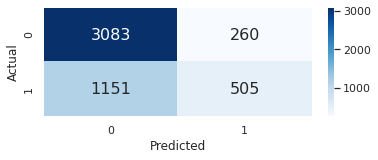

In [ ]:
#@title Final Model A: Random Forest Classifier
model=RandomForestClassifier(n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features='auto', max_depth=40, bootstrap=True, random_state=42)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
evaluate_binary(y_test, y_pred)

---------------------------------------------------
Accuracy:  0.7203
Precision:  0.6913
Recall:  0.2814
F1:  0.4
Benchmark: 0.5888
AUC: 0.6095
---------------------------------------------------


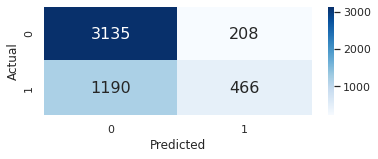

In [ ]:
#@title Final Model B: Gradient Boosting Classifier
model=GBC(learning_rate=.001, loss='deviance', max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=1600, subsample=.25, random_state=42)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
evaluate_binary(y_test, y_pred)

In [ ]:
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")




KeyboardInterrupt: ignored

In [ ]:
for f in range(X.shape[1]):
    print(X_labels[f])
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print('-------------')

X
1. feature 0 (0.291662)
-------------
Y
2. feature 1 (0.283947)
-------------
CALL DAY OF WEEK
3. feature 3 (0.128915)
-------------
CALL HOUR
4. feature 4 (0.111926)
-------------
CALL MONTH
5. feature 2 (0.085545)
-------------
1 or 2 family dwelling \ House \ Residen
6. feature 5 (0.020178)
-------------
Residential street, road or residential
7. feature 7 (0.011327)
-------------
Multifamily dwellings \ Apartments
8. feature 6 (0.008503)
-------------
Street, other
9. feature 17 (0.007082)
-------------
Residential, other
10. feature 8 (0.005606)
-------------
Highway or divided highway
11. feature 19 (0.005188)
-------------
Street or road in commercial area
12. feature 13 (0.004469)
-------------
Vacant lot
13. feature 18 (0.004178)
-------------
Church, mosque, synagogue, temple, chape
14. feature 11 (0.003204)
-------------
Vehicle parking area
15. feature 12 (0.003067)
-------------
Open land or field
16. feature 26 (0.003066)
-------------
Parking garage, (detached resident

#Analysis

###Results and Operationalizing
While I was able to find a better-than-chance predictor with both the Random Forest Classifier and Gradient Boosting Clasifier - evident by the AUCs of .61 - the main takeaway from this research is that false alarms are highly difficult to predict. Especially when you take into account the high cost of a false positive - a predicted False Alarm when it's a real emergency - it is unlikely that a fire department would ever use my model to justify not sending a crew to investigate a call. I think that it is possible that a better model could be formed with more data, but unlikely. Still, the fire departments could use a model like mine to determine which trucks or firefighters should be sent to which locations, or perhaps to investigate where smoke alarms are too sensitive. 

###Possible Further Research
It is possible that this model could be improved if we had a feature explaining how the call was made - was it a phone call, or an automatic call triggered by a smoke alarm, or a pulled fire alarm? Could transcripts of phone calls help as well? 

Additionally, I had a second question in the back of my mind throughout this process: Can we predict when a fire will result in injuries or fatalities? This may be useful for an ambulance service. I created a binary variable which was a 1 if there were any injuries or fatalities and a 0 if there was not. As in the original question, I tried to find a classification model to predict this label. Finding a model that did not predict everything as "No injury/fatality" was taking me too much time, so I decided to dive deeper into my original question instead of looing more into this. Still, it is an area that could be followed up in with more research. I also briefly considered if there were differences in the fire departments' response times based on time of day by working with histograms of time series data, but did not find anything significant. 

#Conclusion
In this lab, I was able to utilize many of the skills I have honed over the course of this semester, including working with time series data, binarizing data, balancing a dataset, choosing the best model given a situation, and tuning hyperparameters. 

I learned that real world datasets are often not as predictable as some of the ones we have looked at in class, and how to communicate results when this is the case. 

Something I learned that I didn't expect to is how easy it is to convince myself that my models are good. For example, my best model only misses real emergencies .042% of the time. I could probably convince some people to use it if I harped on numbers like this. But it's important to realize that this is still 211 emergencies that go undetected out of 4,000 calls - given the context, I don't have an incredible model. I think this is an especially important lesson to learn right now, as scientists roll out more tests for COVID-19.  

#Acknowledgments
I did not receive any help on this project except from Dr. Allen. The only help I gave was to suggest to Kristin that she try the Gradient Boosting Classifier because she was also working with an imbalanced dataset and her best results were Random Forest, but she hadn't tried GBC yet. 

#References
Manipulating Data  
https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timestamp.html  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html  

https://www.datacamp.com/community/tutorials/joining-dataframes-pandas  

https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/  




Displaying Data  
https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

Choosing a Classifier  
https://scikit-learn.org/stable/modules/naive_bayes.html  

https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/  

https://scikit-learn.org/stable/modules/neural_networks_supervised.html  

https://stackoverflow.com/questions/52763325/how-to-obtain-only-the-name-of-a-models-object-in-scikitlearn

https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary

Dealing with Imbalanced Data  
https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36

https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f


Hyperparameter Tuning/Grid Search  
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

